In [1]:
import numpy as np 
import os
import keras
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

2024-08-07 12:05:45.222804: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 12:05:45.222951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 12:05:45.355135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import zipfile

# Clear the session and collect garbage
import gc
from tensorflow.keras import backend as K

def clear_session():
    K.clear_session()
    gc.collect()

clear_session()

# Step 1: Download the dataset using the Kaggle API
!kaggle datasets download -d ninadaithal/imagesoasis

# Step 2: Unzip the downloaded dataset
zip_file_path = 'imagesoasis.zip'
extraction_path = '/kaggle/working/dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Define the base path to the dataset
data_dir = os.path.join(extraction_path, 'Data')  # Update this path if necessary

# Define the paths to the subdirectories
very_mild_dementia_dir = os.path.join(data_dir, 'Very mild Dementia')
non_demented_dir = os.path.join(data_dir, 'Non Demented')
moderate_dementia_dir = os.path.join(data_dir, 'Moderate Dementia')
mild_dementia_dir = os.path.join(data_dir, 'Mild Dementia')

# Function to count images in a directory
def count_images_in_directory(directory):
    if os.path.exists(directory):
        return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
    else:
        print(f"Directory not found: {directory}")
        return 0

# Count images in each class
very_mild_dementia_count = count_images_in_directory(very_mild_dementia_dir)
non_demented_count = count_images_in_directory(non_demented_dir)
moderate_dementia_count = count_images_in_directory(moderate_dementia_dir)
mild_dementia_count = count_images_in_directory(mild_dementia_dir)

# Print the counts
print(f"Total number of images in 'Very mild Dementia': {very_mild_dementia_count}")
print(f"Total number of images in 'Non Demented': {non_demented_count}")
print(f"Total number of images in 'Moderate Dementia': {moderate_dementia_count}")
print(f"Total number of images in 'Mild Dementia': {mild_dementia_count}")

# Create path lists for each class
path1 = []
path2 = []
path3 = []
path4 = []

# Append paths to the lists
for dirname, _, filenames in os.walk(non_demented_dir):
    for filename in filenames:
        path1.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk(mild_dementia_dir):
    for filename in filenames:
        path2.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk(moderate_dementia_dir):
    for filename in filenames:
        path3.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk(very_mild_dementia_dir):
    for filename in filenames:
        path4.append(os.path.join(dirname, filename))

# Print the path lists
print(f"Paths in 'Non Demented': {path1[:5]}...")  # Print first 5 paths as a sample
print(f"Paths in 'Mild Dementia': {path2[:5]}...")
print(f"Paths in 'Moderate Dementia': {path3[:5]}...")
print(f"Paths in 'Very mild Dementia': {path4[:5]}...")


Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): Apache 2.0
imagesoasis.zip: Skipping, found more recently modified local copy (use --force to force download)
Total number of images in 'Very mild Dementia': 13725
Total number of images in 'Non Demented': 67222
Total number of images in 'Moderate Dementia': 488
Total number of images in 'Mild Dementia': 5002
Paths in 'Non Demented': ['/kaggle/working/dataset/Data/Non Demented/OAS1_0265_MR1_mpr-4_147.jpg', '/kaggle/working/dataset/Data/Non Demented/OAS1_0136_MR1_mpr-3_117.jpg', '/kaggle/working/dataset/Data/Non Demented/OAS1_0138_MR1_mpr-3_146.jpg', '/kaggle/working/dataset/Data/Non Demented/OAS1_0051_MR1_mpr-1_104.jpg', '/kaggle/working/dataset/Data/Non Demented/OAS1_0070_MR1_mpr-2_115.jpg']...
Paths in 'Mild Dementia': ['/kaggle/working/dataset/Data/Mild Dementia/OAS1_0291_MR1_mpr-3_149.jpg', '/kaggle/working/dataset/Data/Mild Dementia/OAS1_0134_MR1_mpr-2_158.jpg', '/kaggle/working/dataset/Data/Mild Deme

In [5]:

path1 = path1[0:100]
path2 = path2[0:100]
path3 = path3[0:100]
path4 = path4[0:100]

# Initialize Label Encoder and OneHotEncoder
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

# Fit Label Encoder
labels = [0, 1, 2, 3]
label_encoder.fit(labels)
onehot_encoder.fit(np.array(labels).reshape(-1, 1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [6]:
from PIL import Image
# Prepare data and result lists
data = []
result = []

# Function to process images and append to data and result lists
def process_images(paths, label):
    for path in paths:
        img = Image.open(path)
        img = img.resize((128, 128))
        img = np.array(img)
        if img.shape == (128, 128, 3):
            data.append(img)
            encoded_label = label_encoder.transform([label])
            onehot_encoded_label = onehot_encoder.transform(encoded_label.reshape(-1, 1))
            result.append(onehot_encoded_label[0])

# Process each set of paths
process_images(path1, 0)
process_images(path2, 1)
process_images(path3, 2)
process_images(path4, 3)

# Convert data and result to numpy arrays
data = np.array(data)
result = np.array(result)

# Print shapes to verify
print(f"Data shape: {data.shape}")
print(f"Result shape: {result.shape}")

Data shape: (400, 128, 128, 3)
Result shape: (400, 4)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,844,452 (64.26 MB)

 Trainable params: 16,844,260 (64.26 MB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.3281 - loss: 34.9392

W0000 00:00:1723030300.588613     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/6 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3179 - loss: 35.8698 

W0000 00:00:1723030305.472728     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2873 - loss: 36.1583 - val_accuracy: 0.2167 - val_loss: 35.8208
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.3114 - loss: 34.1412 - val_accuracy: 0.2333 - val_loss: 33.5129
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3481 - loss: 33.0693 - val_accuracy: 0.3500 - val_loss: 32.4415
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2663 - loss: 32.2811 - val_accuracy: 0.2000 - val_loss: 31.7981
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2895 - loss: 31.5498 - val_accuracy: 0.2167 - val_loss: 31.0281
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2516 - loss: 30.8574 - val_accuracy: 0.2167 - val_loss: 30.3247
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2515 - loss: 30.1979 - val_accuracy: 0.2333 - val_loss: 29.6319
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2765 - loss: 29.4722 - val_accuracy: 0.2167 - val_loss: 28.9

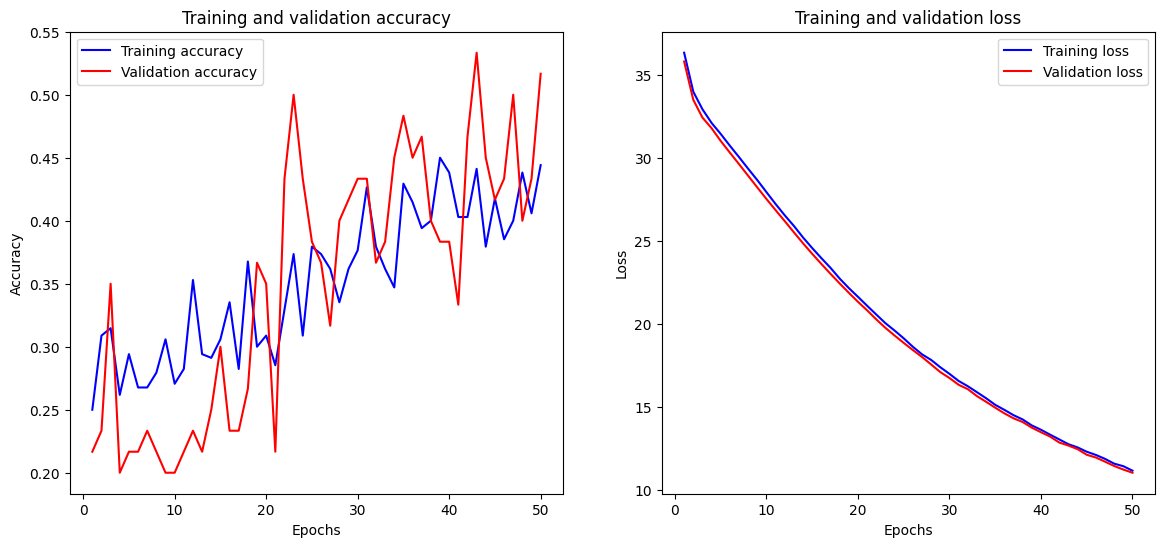

In [45]:
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, result, test_size=0.15, shuffle=True, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

'''# Define the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding='Same'))
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='Same'))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.03)))

optimizer = Adamax(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Summary of the model
model.summary()'''




# Define a model with reduced L2 regularization and increased complexity

# Define the updated model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(128, 128, 3), padding='Same', kernel_regularizer=l2(0.04)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same', kernel_regularizer=l2(0.04)))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Second Convolutional Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='Same', kernel_regularizer=l2(0.05)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='Same', kernel_regularizer=l2(0.04)))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.05)))

# Compile the model with a specific optimizer and learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

# Fit the model using the data generator without the learning rate scheduler
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(x_test, y_test),
                    verbose=1)
# Print final accuracies
final_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")

# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()